<a href="https://colab.research.google.com/github/martingrzzler/colab-notebooks/blob/master/deep_learning_foundations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [401]:
data = pd.read_csv('sample_data/mnist_train_small.csv')
test_data = pd.read_csv('sample_data/mnist_test.csv')

In [402]:
data_np = data.to_numpy()
test_data_np = test_data.to_numpy()
data_np.shape, test_data_np.shape

((19999, 785), (9999, 785))

In [403]:
Y = data_np[:,0]
X = data_np[:,1:]
Y_test = test_data_np[:,0]
X_test = test_data_np[:,1:]
N = X.shape[0]

In [404]:
dims = np.sqrt(X[0].shape[0]).astype(int)

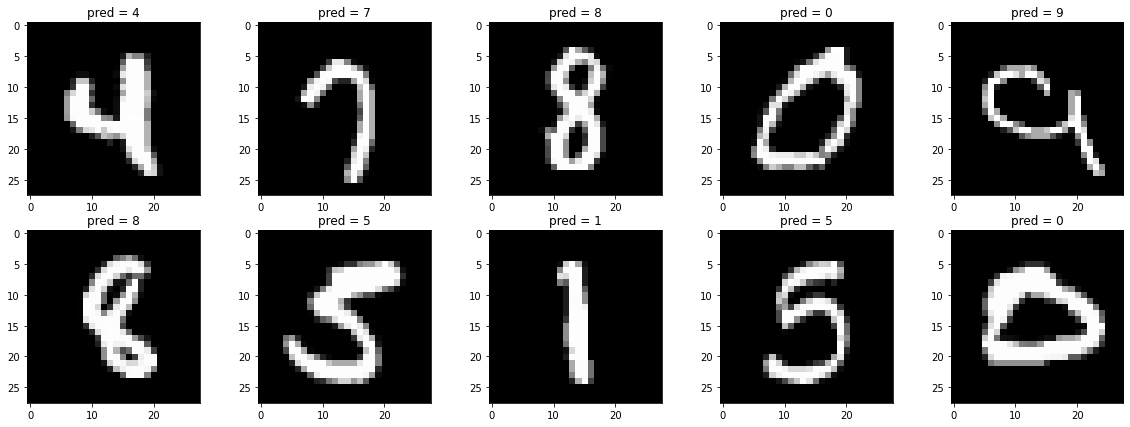

In [405]:
fig, axs = plt.subplots(2,5,figsize=(20,7))
for ax in axs.flat:
  index = np.random.randint(0, N)
  img = X[index].reshape((dims,dims))
  ax.set_title(f"pred = {Y[index]}")
  ax.imshow(img, cmap='gray', vmin=0, vmax=255)


(array([1962., 2243., 1989., 2021., 1924., 1761., 2038., 2126., 1912.,
        2023.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

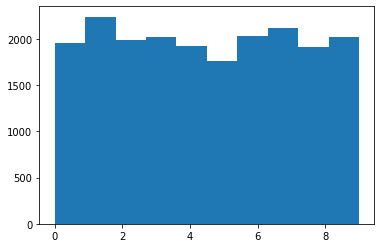

In [406]:
plt.hist(Y, bins=10)
# evenly distributed

In [407]:
X_norm = X / np.max(X)
X_test_norm = X_test / np.max(X_test)

Now that I have labels and training data let's build the Neural Network.

### Cost function and Gradient Descent

This is a categorical problem so I will use the `Cross Entropy Function`. Why choosing any particular cost function? Minimizing the cost is the same as finding a solution to a maximum likelihood problem. The likelihood tells us how likely it is that the data can be modeled by a particular distribution with certain parameters. Depending on what parameters one uses this liklihood will be bigger or smaller. In practice the likelyhood is the product over all datapoint's PDF function: $\prod_{i=1}^{N} PDF(x_i; w)$. In the case of a categorical distribution it is $\prod_{n=1}^{N}\prod_{k=1}^K p_k^{[t_n=k]}$. This is often transformed to the log likelihood which makes taking the derivative easier and numbers more stable as a product of probabilities becomes very small very fast.

$\sum_{n=1}^{N}\sum_{k=1}^K [t_n=k] \log(p_k)$

Now imagine the $p_k$ to be the probability the model predicts. If it predicts one for the correct target it outputs zero. If it predicts 0.5 for the correct target the win will be $1 \log(0.5) = -0.693$. So as the prediciton goes more wrong the win drops as well. Notice in order to turn this into a loss function rather than "win" function, simply add a negative sign. In that case 0.6 will mean a higher loss than 0. Without the negative sigm one must go uphill when doing gradient descent.

### Architecure

<img width="300" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/basic-nn.png" />

#### Definitions
$D=784$ - number of input features\
$M=16$ - number of hidden layer nodes\
$K=10$ - number of output nodes\
<br/>
Forward pass:\
$α=W^Tx+b$\
$z=σ(α)$\
$a=V^Tz+c$\
$y=softmax(a)$\
<br/>
$J=\sum_{n=1}^N\sum_{k=1}^Kt_{nk}log(y_{nk})$ - the loss function\
<br/>
#### Derivatives
_Softmax_:\
$\frac{δJ}{δa_{nk}}=∑^N_{n=1}∑_{k'=1}^K\frac{δJ}{δy_{nk'}}\frac{δy_{nk'}}{δa_{nk}}$\
$\frac{δJ}{δa_{nk}}=y_{nk'}(𝛅-y_{nk})$\
$𝜹=\binom{k'=k→1}{k'!=k→0}$\
<img width="500" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/softmax_derivative.jpg" /><br/>
_Cross Entropy Loss_:\
$\frac{δJ}{δy_{nk'}}=\frac{t_{nk'}}{y_{nk'}}$\
Bringing them together:\
$\sum_{n=1}^N\sum_{k'=1}^Kt_{nk'}(𝛅_{kk'}-y_nk)$\
<br/>
split the sum
<br/>
1. $\sum_{k'=1}^Kt_{k'}𝛅_{kk'}=t_k$ because $t_k*1 + 0 = t_k$\
<br/>
2. $\sum_{k'=1}^Kt_{k'}y_{k}=y_k\sum_{k'=1}^Kt_k'=y_k*1=y_k$
<br/>


$\sum_{n=1}^N(t_{nk}-y_{nk})$\
<br/>
$𝚫J=X^T(T-Y)$\

_Sigmoid_:

<img width="250" src="https://raw.githubusercontent.com/martingrzzler/colab-notebooks/master/images/sigmoid_derivative.jpg" /><br/>

so the derivatives for $c,V,b,W$:\
$δJ/δV_{nk}=\sum_{n=1}^N(t_{nk}-y_{nk})z_{nm}$\
$δJ/δc_{nk}=\sum_{n=1}^N(t_{nk}-y_{nk})$\
$δJ/δW_{dm}=\sum_{n=1}^N\sum_{k=1}^K(t_{nk}-y_{nk})V_{mk}z_{nm}(1-z_{nm})x_{nd}$\
$δJ/δb_{dm}=\sum_{n=1}^N\sum_{k=1}^K(t_{nk}-y_{nk})V_{mk}z_{nm}(1-z_{nm})$






In [408]:
def cost(T, Y):
  tot = T * np.log(Y)
  return tot.sum()

def forward(X, W, b, V, c):
  Z = 1 / (1 + np.exp(-X.dot(W) - b))
  A = Z.dot(V) + c
  expA = np.exp(A)
  Y = expA / expA.sum(axis=1, keepdims=True)
  return Y, Z

def derivative_V(Z, T, Y):
  return Z.T.dot(T - Y)

def derivative_c(T, Y):
  return (T - Y).sum(axis=0)

def derivative_W(X, Z, T, Y, V):
    dZ = (T - Y).dot(V.T) * Z * (1 - Z)
    return X.T.dot(dZ)

def derivative_b(T, Y, V, Z):
    return ((T - Y).dot(V.T) * Z * (1 - Z)).sum(axis=0)

def accuracy(Y, P):
  return np.mean(Y==P)


def to_indicator(Y, N, K):
  T = np.zeros((N,K))
  for n in range(N):
    T[n,Y[n]] = 1
  return T

def unison_shuffle(A, B, C):
  assert(len(A) == len(B) == len(C))
  p = np.random.permutation(len(A))
  return A[p], B[p], C[p]


epoch: 0 win: -76658.09700238549 accuracy: 0.11160558027901395
epoch: 20 win: -39043.48310198177 accuracy: 0.2863643182159108
epoch: 40 win: -29892.809790507305 accuracy: 0.4705735286764338
epoch: 60 win: -23345.329603027236 accuracy: 0.5868293414670733
epoch: 80 win: -20526.47608804151 accuracy: 0.6363818190909546
epoch: 100 win: -17907.29240589867 accuracy: 0.7174358717935897
epoch: 120 win: -16863.823272742815 accuracy: 0.7456872843642182
epoch: 140 win: -14865.649693332685 accuracy: 0.776088804440222
epoch: 160 win: -14939.61985365251 accuracy: 0.7903395169758488
epoch: 180 win: -14780.431670396845 accuracy: 0.816040802040102
epoch: 200 win: -11958.569790170339 accuracy: 0.8271413570678534
epoch: 220 win: -11451.133616158508 accuracy: 0.8412920646032301
epoch: 240 win: -10210.324474731935 accuracy: 0.8659932996649833
epoch: 260 win: -10424.640464128519 accuracy: 0.8604430221511076
epoch: 280 win: -10482.813151296854 accuracy: 0.8508425421271063
epoch: 300 win: -9905.65856761465 acc

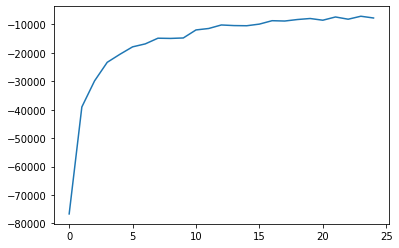

In [415]:
from pandas.core.resample import g
D = X[0].shape[0]
M = 16
K = 10
T = to_indicator(Y, N, K)

# initialize weights
W = np.random.randn(D, M)
b = np.zeros(M)
V = np.random.randn(M, K)
c = np.zeros(K)

learning_rate = 0.001
costs = []
batch_size = 256

for epoch in range(500):
  # X_shuffled, T_shuffled, Y_shuffled = unison_shuffle(X_norm,T,Y)
  # for batch in range(batch_size):
    # X_batch = X_shuffled[batch*batch_size:(batch+1)*batch_size,:]
    # T_batch = T_shuffled[batch*batch_size:(batch+1)*batch_size,:]

  output, hidden = forward(X_norm, W, b, V, c)
  # current_batch_size = len(X_batch)

  if epoch % 20 == 0:
    win = cost(T, output)
    P = np.argmax(output, axis=1)
    print("epoch:", epoch, "win:", win, "accuracy:", accuracy(Y,P))
    costs.append(win)

  gV = derivative_V(hidden,T, output)  
  gc = derivative_c(T,output)  
  gW = derivative_W(X_norm,hidden,T,output,V) 
  gb = derivative_b(T, output, V, hidden)  

  V += learning_rate * gV
  c += learning_rate * gc
  W += learning_rate * gW
  b += learning_rate * gb

# test accuracy
P_test_proba, _ = forward(X_test_norm, W, b, V, c)
P_test = np.argmax(P_test_proba, axis=1)
print("test accuracy:", accuracy(Y_test, P_test))

plt.plot(costs)
plt.show()